# Calibration Tutorial - Crane, OR - Irrigated Flux Plot

## Step 1: Uncalibrated Model Run

This tutorial focuses on calibrating SWIM-RS for a single irrigated alfalfa plot at the S2 flux station in Crane, Oregon. Unlike the unirrigated Fort Peck example, this site is actively irrigated.

This notebook demonstrates:
1. Loading pre-built model input data
2. Running the uncalibrated SWIM model
3. Comparing model output with OpenET ensemble (PT-JPL, SIMS, SSEBop, geeSEBAL)
4. Validation against flux tower observations using multiple metrics (R², r, RMSE, bias)

**Input Data:** The `data/prepped_input.json` file contains pre-computed input data.

### Data Pipeline

The full data workflow uses two scripts and can be re-run if needed:

1. **`extract_data.py`** - Extracts raw data from Earth Engine and GridMET to CSV/parquet files
2. **`build_inputs.py`** - Processes extracted data through SwimContainer and exports to `prepped_input.json`

To reproduce the input data from scratch:

```bash
cd data
python extract_data.py    # Extract from EE/GridMET (requires authentication)
python build_inputs.py    # Build container and export JSON
```

See `data/extract_data.py` for extraction options and `data/build_inputs.py` for container workflow details.

In [1]:
import os
import sys
import time
import tempfile
import zipfile

import numpy as np
import pandas as pd
from scipy import stats
from sklearn.metrics import mean_squared_error, r2_score

root = os.path.abspath('../..')
sys.path.append(root)

from swimrs.swim.config import ProjectConfig
from swimrs.container import SwimContainer
from swimrs.process.input import build_swim_input
from swimrs.process.loop_fast import run_daily_loop_fast

from swimrs.viz.swim_timeseries import plot_swim_timeseries

%matplotlib inline

## 1. Project Setup

Define paths and unzip pre-built data if needed.

In [2]:
project_ws = os.path.abspath('.')
data = os.path.join(project_ws, 'data')

config_file = os.path.join(project_ws, '3_Crane.toml')
prepped_input = os.path.join(data, 'prepped_input.json')

# Unzip data files if they haven't been extracted
prepped_zip = os.path.join(data, 'prepped_input.zip')

if os.path.exists(prepped_zip) and not os.path.exists(prepped_input):
    print("Extracting prepped_input.zip...")
    with zipfile.ZipFile(prepped_zip, 'r') as z:
        z.extractall(data)

# Unzip flux tower data if needed
flux_zip = os.path.join(data, 'S2_daily_data.zip')
flux_csv = os.path.join(data, 'S2_daily_data.csv')

if os.path.exists(flux_zip) and not os.path.exists(flux_csv):
    print("Extracting S2_daily_data.zip...")
    with zipfile.ZipFile(flux_zip, 'r') as z:
        z.extractall(data)

print(f"Project workspace: {project_ws}")
print(f"Config file: {config_file}")
print(f"Input data: {prepped_input}")

Project workspace: /home/dgketchum/code/swim-rs/examples/3_Crane
Config file: /home/dgketchum/code/swim-rs/examples/3_Crane/3_Crane.toml
Input data: /home/dgketchum/code/swim-rs/examples/3_Crane/data/prepped_input.json


In [3]:
# Load the project configuration
config = ProjectConfig()
config.read_config(config_file, project_ws)

### Initial Parameter Values

The model will run with the following default parameter values and bounds:

In [4]:
from swimrs.calibrate.pest_builder import PestBuilder

def show_parameter_table(config, container_path):
    """Display parameter bounds and initial values from PestBuilder."""
    container = SwimContainer.open(container_path, mode='r')
    try:
        builder = PestBuilder(config, container=container)
        params = builder.initial_parameter_dict()
    finally:
        container.close()
    
    print("=" * 80)
    print("INITIAL PARAMETER VALUES AND BOUNDS")
    print("=" * 80)
    print(f"{'Parameter':<12} {'Initial':>12} {'Lower':>10} {'Upper':>10} {'Std':>8}  Description")
    print("-" * 80)
    
    descriptions = {
        'aw': 'Available water capacity (mm)',
        'ks_alpha': 'Soil evap stress damping',
        'kr_alpha': 'Root zone stress damping', 
        'ndvi_k': 'NDVI-Kcb slope',
        'ndvi_0': 'NDVI-Kcb intercept',
        'mad': 'Management allowable depletion',
        'swe_alpha': 'Snow melt temp coefficient',
        'swe_beta': 'Snow melt rate coefficient',
    }
    
    for name, p in params.items():
        init = p['initial_value']
        if init is None:
            init_str = 'auto'
        elif isinstance(init, str):
            init_str = init[:12]
        else:
            init_str = f"{init:.2f}"
        print(f"{name:<12} {init_str:>12} {p['lower_bound']:>10.2f} {p['upper_bound']:>10.2f} {p['std']:>8.2f}  {descriptions.get(name, '')}")
    
    print("=" * 80)

container_path = os.path.join(data, '3_Crane.swim')
if os.path.exists(container_path):
    show_parameter_table(config, container_path)
else:
    print("Container not found - run build_inputs.py first to see parameter table")

/home/dgketchum/miniconda/envs/swim/lib/python3.11/site-packages/pyemu/__init__.py:37: UserWarning: Failed to import legacy module. May impact ability to access older methods.ModuleNotFoundError No module named 'flopy'


Using default Python script at: /home/dgketchum/code/swim-rs/src/swimrs/calibrate/custom_forward_run.py
INITIAL PARAMETER VALUES AND BOUNDS
Parameter         Initial      Lower      Upper      Std  Description
--------------------------------------------------------------------------------
aw                   auto     100.00     400.00    50.00  Available water capacity (mm)
ks_alpha             0.50       0.01       1.00     0.15  Soil evap stress damping
kr_alpha             0.50       0.01       1.00     0.15  Root zone stress damping
ndvi_k               7.00       4.00      10.00     0.75  NDVI-Kcb slope
ndvi_0               0.40       0.10       0.70     0.25  NDVI-Kcb intercept
mad                  auto       0.01       0.90     0.15  Management allowable depletion
swe_alpha            0.30      -0.50       1.00     0.20  Snow melt temp coefficient
swe_beta             1.50       0.50       2.50     0.30  Snow melt rate coefficient


## 2. About the Study Site

The S2 site is an irrigated alfalfa field in Crane, Oregon. According to IrrMapper data, this location has been irrigated since about 1996, making it a good test case for the irrigation scheduling component of SWIM-RS.

In [5]:
selected_feature = 'S2'

print(f"Site: {selected_feature}")
print(f"Location: Crane, Oregon")
print(f"Crop: Irrigated alfalfa")
print(f"Date range: {config.start_dt} to {config.end_dt}")

Site: S2
Location: Crane, Oregon
Crop: Irrigated alfalfa
Date range: 1987-01-01 00:00:00 to 2022-12-31 00:00:00


## 3. Run the Uncalibrated Model

We define a helper function to run the SWIM model and capture its output.

In [6]:
def run_fields(config, container, selected_feature, output_csv, start_date=None, end_date=None):
    """Run SWIM model using the process package and save output to CSV.
    
    Uses the modern process package workflow:
    1. Build SwimInput from container
    2. Run simulation with run_daily_loop_fast()
    3. Convert DailyOutput to DataFrame with time series
    4. Add ETf observations from container for comparison
    
    Parameters
    ----------
    start_date : str, optional
        Override start date (YYYY-MM-DD). Use when met data doesn't cover full range.
    end_date : str, optional  
        Override end date (YYYY-MM-DD). Use when met data doesn't cover full range.
    """
    start_time = time.time()

    # Create temporary HDF5 for SwimInput
    with tempfile.NamedTemporaryFile(suffix='.h5', delete=False) as tmp:
        temp_h5_path = tmp.name
    
    try:
        # Build SwimInput from container
        swim_input = build_swim_input(
            container,
            output_h5=temp_h5_path,
            runoff_process=getattr(config, 'runoff_process', 'cn'),
            etf_model=getattr(config, 'etf_target_model', 'ssebop'),
            met_source=getattr(config, 'met_source', 'gridmet'),
            fields=[selected_feature],
            start_date=start_date,
            end_date=end_date,
        )
        
        # Run simulation (uses fast JIT-compiled loop)
        output, final_state = run_daily_loop_fast(swim_input)
        
        # Get time series data
        n_days = swim_input.n_days
        dates = pd.date_range(swim_input.start_date, periods=n_days, freq='D')
        
        # Get input time series for DataFrame
        etr = swim_input.get_time_series('etr')
        prcp = swim_input.get_time_series('prcp')
        tmin = swim_input.get_time_series('tmin')
        tmax = swim_input.get_time_series('tmax')
        ndvi = swim_input.get_time_series('ndvi')
        
        # Build DataFrame (field index 0 since we're doing single field)
        i = 0
        df_data = {
            # Model outputs
            'et_act': output.eta[:, i],
            'etref': etr[:, i],
            'kc_act': output.etf[:, i],
            'kc_bas': output.kcb[:, i],
            'ks': output.ks[:, i],
            'ke': output.ke[:, i],
            'melt': output.melt[:, i],
            'rain': output.rain[:, i],
            'depl_root': output.depl_root[:, i],
            'dperc': output.dperc[:, i],
            'runoff': output.runoff[:, i],
            'swe': output.swe[:, i],
            'irrigation': output.irr_sim[:, i],
            'gw_sim': output.gw_sim[:, i],
            # Input time series
            'ppt': prcp[:, i],
            'tmin': tmin[:, i],
            'tmax': tmax[:, i],
            'tavg': (tmin[:, i] + tmax[:, i]) / 2.0,
            'ndvi': ndvi[:, i],
        }
        
        # Calculate derived columns
        df_data['soil_water'] = swim_input.properties.awc[i] - output.depl_root[:, i]
        
        df = pd.DataFrame(df_data, index=dates)
        
        swim_input.close()
        
        # Load ETf observations from container for comparison
        etf_model = getattr(config, 'etf_target_model', 'ssebop')
        
        for mask in ['inv_irr', 'irr']:
            if etf_model == 'ensemble':
                # Compute ensemble mean from all available models
                known_models = ['ssebop', 'ptjpl', 'sims', 'geesebal', 'eemetric', 'disalexi']
                mask_data = []
                for model in known_models:
                    etf_path = f"remote_sensing/etf/landsat/{model}/{mask}"
                    try:
                        etf_df = container.query.dataframe(etf_path, fields=[selected_feature])
                        if selected_feature in etf_df.columns:
                            mask_data.append(etf_df[selected_feature])
                    except Exception:
                        pass
                
                if mask_data:
                    combined = pd.concat(mask_data, axis=1)
                    ensemble_mean = combined.mean(axis=1)
                    etf_series = ensemble_mean.reindex(dates)
                    df[f'etf_{mask}'] = etf_series.values
                    print(f"Loaded ensemble ETf for {mask} from {len(mask_data)} models")
                else:
                    print(f"Warning: No ETf models found for {mask}")
                    df[f'etf_{mask}'] = np.nan
            else:
                etf_path = f"remote_sensing/etf/landsat/{etf_model}/{mask}"
                try:
                    etf_df = container.query.dataframe(etf_path, fields=[selected_feature])
                    etf_series = etf_df[selected_feature].reindex(dates)
                    df[f'etf_{mask}'] = etf_series.values
                except Exception as e:
                    print(f"Warning: Could not load ETf for {mask}: {e}")
                    df[f'etf_{mask}'] = np.nan
        
    finally:
        # Clean up temp file
        if os.path.exists(temp_h5_path):
            os.remove(temp_h5_path)
    
    end_time = time.time()
    print(f'\nExecution time: {end_time - start_time:.2f} seconds\n')

    df.to_csv(output_csv)
    
    return df

In [7]:
selected_feature = 'S2'
out_csv = os.path.join(project_ws, f'combined_output_{selected_feature}_uncalibrated.csv')

# Open container for model run
container_path = os.path.join(data, '3_Crane.swim')
container = SwimContainer.open(container_path, mode='r')

try:
    df = run_fields(config, container, selected_feature=selected_feature, output_csv=out_csv)
finally:
    container.close()

Loaded ensemble ETf for inv_irr from 4 models
Loaded ensemble ETf for irr from 4 models

Execution time: 1.25 seconds



In [8]:
print(f"Output shape: {df.shape}")
print(f"Date range: {df.index[0]} to {df.index[-1]}")
print(f"\nKey output columns:")
key_cols = ['et_act', 'etref', 'kc_act', 'kc_bas', 'ks', 'ke', 'melt', 'rain', 
            'depl_root', 'swe', 'ppt', 'irrigation', 'soil_water']
for col in key_cols:
    if col in df.columns:
        print(f"  {col}: mean={df[col].mean():.3f}, max={df[col].max():.3f}")

Output shape: (13149, 22)
Date range: 1987-01-01 00:00:00 to 2022-12-31 00:00:00

Key output columns:
  et_act: mean=1.768, max=8.165
  etref: mean=3.156, max=9.600
  kc_act: mean=0.553, max=0.968
  kc_bas: mean=0.477, max=0.974
  ks: mean=0.944, max=1.000
  ke: mean=0.282, max=0.513
  melt: mean=0.167, max=25.989
  rain: mean=0.531, max=25.900
  depl_root: mean=36.634, max=246.444
  swe: mean=1.635, max=97.300
  ppt: mean=0.699, max=25.900
  irrigation: mean=1.044, max=25.000
  soil_water: mean=63.366, max=131.000


## 4. Visualize Model Output

Let's examine a single year (2004) to see the model's behavior.

In [9]:
ydf = df.loc['2004-01-01': '2004-12-31']
print(f'Total irrigation: {ydf.irrigation.sum():.1f} mm')
print(f'Total ET: {ydf.et_act.sum():.1f} mm')
print(f'Total precipitation: {ydf.ppt.sum():.1f} mm')

plot_swim_timeseries(ydf, ['et_act', 'etref', 'rain', 'melt', 'irrigation'], 
                     start='2004-01-01', end='2004-12-31', png_dir='et_uncalibrated.png')

Total irrigation: 472.4 mm
Total ET: 703.9 mm
Total precipitation: 267.7 mm
et_uncalibrated.png


## 5. Compare with Flux Tower Observations

We compare three estimates of actual ET (mm/day):

1. **SWIM ET**: Model-estimated actual evapotranspiration (daily)
2. **OpenET Ensemble ET**: Remote sensing retrievals from OpenET (PT-JPL, SIMS, SSEBop, geeSEBAL) averaged together (ETf × ETo)
3. **Flux ET**: Independent observations from the S2 eddy covariance tower (Volk et al.)

We show two comparisons:
- **Capture dates only**: Both methods compared only on Landsat overpass dates
- **Full time series**: SWIM (daily) vs OpenET (interpolated between Landsat dates) on all flux tower days

In [10]:
def compare_et_estimates(combined_output_path, flux_data_path, irr=True):
    """Compare model ET and OpenET ensemble ET against flux tower observations.
    
    Returns two comparison DataFrames:
    1. Capture dates only: Both methods on Landsat overpass dates only
    2. Full time series: SWIM daily, OpenET interpolated, on all flux tower days
    
    Reports R², Pearson r, bias, and RMSE for each comparison.
    """
    flux_data = pd.read_csv(flux_data_path, index_col='date', parse_dates=True)
    flux_et = flux_data['ET']  # Actual ET from flux tower (mm/day)

    output = pd.read_csv(combined_output_path, index_col=0)
    output.index = pd.to_datetime(output.index)

    # Determine suffix based on irrigation mask
    mask_suffix = 'irr' if irr else 'inv_irr'
    
    # OpenET ensemble models - compute mean ETf across available models
    ensemble_models = ['ptjpl', 'sims', 'ssebop', 'geesebal']
    etf_cols = []
    for model in ensemble_models:
        col_name = f'etf_{model}_{mask_suffix}'
        if col_name in output.columns:
            etf_cols.append(col_name)
    
    # Fallback to single SSEBop if ensemble columns not available
    if not etf_cols:
        etf_col = f'etf_{mask_suffix}'
        if etf_col in output.columns:
            etf_cols = [etf_col]
            print(f"Using single ETf column: {etf_col}")
        else:
            print(f"Warning: No ETf columns found for mask '{mask_suffix}'")
            return pd.DataFrame(), pd.DataFrame()
    
    print(f"Using ETf columns: {etf_cols}")
    
    # Compute ensemble mean ETf (ignoring NaN)
    ensemble_etf = output[etf_cols].mean(axis=1, skipna=True)
    
    # Calculate actual ET from OpenET ensemble: ETf × ETo (sparse, only on Landsat dates)
    openet_et_sparse = ensemble_etf * output['etref']
    
    # Linear interpolation of OpenET to get daily values
    openet_et_interp = openet_et_sparse.interpolate(method='linear')
    
    # Count original OpenET observations
    n_openet_obs = openet_et_sparse.notna().sum()

    # CAPTURE DATES ONLY comparison (OpenET sparse)
    capture_df = pd.DataFrame({
        'swim_et': output['et_act'],
        'openet_et': openet_et_sparse,
        'flux_et': flux_et
    }).dropna()

    # FULL TIME SERIES comparison (OpenET interpolated)
    full_df = pd.DataFrame({
        'swim_et': output['et_act'],
        'openet_et': openet_et_interp,
        'flux_et': flux_et
    }).dropna()

    def calc_metrics(df, col1, col2):
        r, _ = stats.pearsonr(df[col1], df[col2])
        r2 = r2_score(df[col1], df[col2])
        rmse = np.sqrt(mean_squared_error(df[col1], df[col2]))
        bias = (df[col2] - df[col1]).mean()
        return r2, r, rmse, bias

    # Capture dates metrics
    r2_swim_cap, r_swim_cap, rmse_swim_cap, bias_swim_cap = calc_metrics(capture_df, 'flux_et', 'swim_et')
    r2_openet_cap, r_openet_cap, rmse_openet_cap, bias_openet_cap = calc_metrics(capture_df, 'flux_et', 'openet_et')

    # Full time series metrics
    r2_swim_full, r_swim_full, rmse_swim_full, bias_swim_full = calc_metrics(full_df, 'flux_et', 'swim_et')
    r2_openet_full, r_openet_full, rmse_openet_full, bias_openet_full = calc_metrics(full_df, 'flux_et', 'openet_et')

    print("="*70)
    print(f"CAPTURE DATES ONLY ({len(capture_df)} Landsat overpass dates)")
    print("="*70)
    print(f"{'Metric':<12} {'SWIM ET':>12} {'OpenET ET':>12}")
    print("-" * 38)
    print(f"{'R²':<12} {r2_swim_cap:>12.3f} {r2_openet_cap:>12.3f}")
    print(f"{'Pearson r':<12} {r_swim_cap:>12.3f} {r_openet_cap:>12.3f}")
    print(f"{'Bias (mm)':<12} {bias_swim_cap:>12.3f} {bias_openet_cap:>12.3f}")
    print(f"{'RMSE (mm)':<12} {rmse_swim_cap:>12.3f} {rmse_openet_cap:>12.3f}")
    
    print()
    print("="*70)
    print(f"FULL TIME SERIES ({len(full_df)} days, OpenET interpolated from {n_openet_obs} obs)")
    print("="*70)
    print(f"{'Metric':<12} {'SWIM ET':>12} {'OpenET ET':>12}")
    print("-" * 38)
    print(f"{'R²':<12} {r2_swim_full:>12.3f} {r2_openet_full:>12.3f}")
    print(f"{'Pearson r':<12} {r_swim_full:>12.3f} {r_openet_full:>12.3f}")
    print(f"{'Bias (mm)':<12} {bias_swim_full:>12.3f} {bias_openet_full:>12.3f}")
    print(f"{'RMSE (mm)':<12} {rmse_swim_full:>12.3f} {rmse_openet_full:>12.3f}")

    return full_df, capture_df

In [11]:
# Use irrigated mask since this is an irrigated site
flux_data = os.path.join(data, 'S2_daily_data.csv')
full_df, capture_df = compare_et_estimates(out_csv, flux_data, irr=True)

Using single ETf column: etf_irr
Using ETf columns: ['etf_irr']
CAPTURE DATES ONLY (91 Landsat overpass dates)
Metric            SWIM ET    OpenET ET
--------------------------------------
R²                  0.748        0.808
Pearson r           0.881        0.921
Bias (mm)           0.150        0.335
RMSE (mm)           1.057        0.923

FULL TIME SERIES (1546 days, OpenET interpolated from 565 obs)
Metric            SWIM ET    OpenET ET
--------------------------------------
R²                  0.691        0.612
Pearson r           0.866        0.869
Bias (mm)           0.268        0.543
RMSE (mm)           1.022        1.146


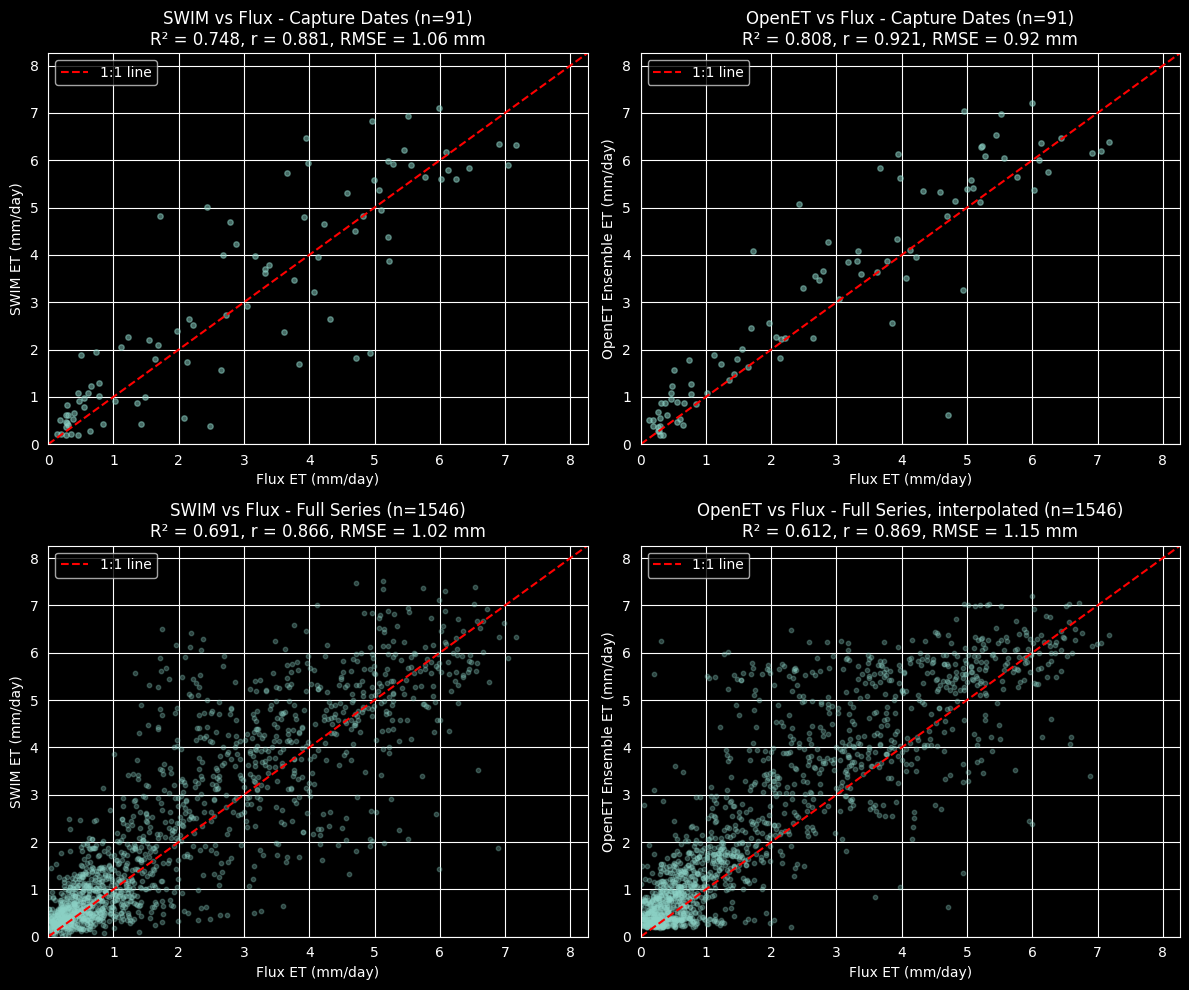

In [12]:
import matplotlib.pyplot as plt

# Create 2x2 scatter plots for both comparisons
fig, axes = plt.subplots(2, 2, figsize=(12, 10))

# Helper function to calculate metrics
def calc_metrics(df, col1, col2):
    r, _ = stats.pearsonr(df[col1], df[col2])
    r2 = r2_score(df[col1], df[col2])
    rmse = np.sqrt(mean_squared_error(df[col1], df[col2]))
    return r2, r, rmse

# Determine axis limits
max_et = max(full_df['flux_et'].max(), full_df['swim_et'].max(), 
             full_df['openet_et'].max()) * 1.1

# TOP ROW: Capture dates only
r2_swim_cap, r_swim_cap, rmse_swim_cap = calc_metrics(capture_df, 'flux_et', 'swim_et')
r2_openet_cap, r_openet_cap, rmse_openet_cap = calc_metrics(capture_df, 'flux_et', 'openet_et')

ax = axes[0, 0]
ax.scatter(capture_df['flux_et'], capture_df['swim_et'], alpha=0.5, s=15)
ax.plot([0, max_et], [0, max_et], 'r--', label='1:1 line')
ax.set_xlabel('Flux ET (mm/day)')
ax.set_ylabel('SWIM ET (mm/day)')
ax.set_title(f'SWIM vs Flux - Capture Dates (n={len(capture_df)})\n'
             f'R² = {r2_swim_cap:.3f}, r = {r_swim_cap:.3f}, RMSE = {rmse_swim_cap:.2f} mm')
ax.legend()
ax.set_xlim(0, max_et)
ax.set_ylim(0, max_et)

ax = axes[0, 1]
ax.scatter(capture_df['flux_et'], capture_df['openet_et'], alpha=0.5, s=15)
ax.plot([0, max_et], [0, max_et], 'r--', label='1:1 line')
ax.set_xlabel('Flux ET (mm/day)')
ax.set_ylabel('OpenET Ensemble ET (mm/day)')
ax.set_title(f'OpenET vs Flux - Capture Dates (n={len(capture_df)})\n'
             f'R² = {r2_openet_cap:.3f}, r = {r_openet_cap:.3f}, RMSE = {rmse_openet_cap:.2f} mm')
ax.legend()
ax.set_xlim(0, max_et)
ax.set_ylim(0, max_et)

# BOTTOM ROW: Full time series comparison
r2_swim, r_swim, rmse_swim = calc_metrics(full_df, 'flux_et', 'swim_et')
r2_openet, r_openet, rmse_openet = calc_metrics(full_df, 'flux_et', 'openet_et')

ax = axes[1, 0]
ax.scatter(full_df['flux_et'], full_df['swim_et'], alpha=0.3, s=10)
ax.plot([0, max_et], [0, max_et], 'r--', label='1:1 line')
ax.set_xlabel('Flux ET (mm/day)')
ax.set_ylabel('SWIM ET (mm/day)')
ax.set_title(f'SWIM vs Flux - Full Series (n={len(full_df)})\n'
             f'R² = {r2_swim:.3f}, r = {r_swim:.3f}, RMSE = {rmse_swim:.2f} mm')
ax.legend()
ax.set_xlim(0, max_et)
ax.set_ylim(0, max_et)

ax = axes[1, 1]
ax.scatter(full_df['flux_et'], full_df['openet_et'], alpha=0.3, s=10)
ax.plot([0, max_et], [0, max_et], 'r--', label='1:1 line')
ax.set_xlabel('Flux ET (mm/day)')
ax.set_ylabel('OpenET Ensemble ET (mm/day)')
ax.set_title(f'OpenET vs Flux - Full Series, interpolated (n={len(full_df)})\n'
             f'R² = {r2_openet:.3f}, r = {r_openet:.3f}, RMSE = {rmse_openet:.2f} mm')
ax.legend()
ax.set_xlim(0, max_et)
ax.set_ylim(0, max_et)

plt.tight_layout()
plt.savefig('comparison_scatter_uncalibrated.png', dpi=150)
plt.show()

## Summary

The uncalibrated model using default parameters shows the baseline performance before calibration. We compared both SWIM and the OpenET ensemble (PT-JPL, SIMS, SSEBop, geeSEBAL average) against independent flux tower observations.

**Two comparison modes:**
- **Capture dates**: Only Landsat overpass dates where we have satellite observations
- **Full time series**: All flux tower days, with OpenET values interpolated between satellite dates

**Key observations:**
- The model isn't applying enough irrigation
- The NDVI-to-Kcb relationship needs tuning for alfalfa
- Soil parameters may not match the actual site conditions
- OpenET ensemble provides robust remote sensing benchmark

**Next step:** In notebook `02_calibration.ipynb`, we'll use PEST++ to calibrate the model parameters using SSEBop ETf and SNODAS SWE observations.

**Key insight:** We're not using the flux data for calibration - it's only for validation. For calibration, we rely solely on widely-available remote sensing data (ETf and SNODAS SWE).

## Optional: Query Data from SwimContainer

If you've built the container using `build_inputs.py`, you can query ingested data directly:

In [13]:
# Query container data (optional - requires build_inputs.py to have been run)
from swimrs.container import SwimContainer

container_path = os.path.join(data, '3_Crane.swim')

if os.path.exists(container_path):
    container = SwimContainer.open(container_path, mode='r')
    
    # List available fields
    print(f"Fields in container: {container.field_uids}")
    
    # Get all time series for a single field using field_timeseries
    ts_df = container.query.field_timeseries('S2')
    print(f"\nTime series shape: {ts_df.shape}")
    print(f"Variables: {list(ts_df.columns)[:10]}...")
    
    # Query specific data using dataframe with zarr paths
    # Path structure: remote_sensing/{type}/{instrument}/{model}/{mask}
    ndvi_df = container.query.dataframe("remote_sensing/ndvi/landsat/irr", fields=['S2'])
    print(f"\nNDVI observations: {ndvi_df.notna().sum().values[0]}")
    
    etf_df = container.query.dataframe("remote_sensing/etf/landsat/ssebop/irr", fields=['S2'])
    print(f"ETf observations: {etf_df.notna().sum().values[0]}")
    
    # Show container status
    print("\n" + container.query.status())
    
    container.close()
else:
    print(f"Container not found at {container_path}")
    print("Run: cd data && python build_inputs.py")

Fields in container: ['S2']

Time series shape: (13149, 24)
Variables: ['meteorology_gridmet_ea', 'meteorology_gridmet_etr_corr', 'meteorology_gridmet_etr', 'meteorology_gridmet_eto', 'meteorology_gridmet_tmin', 'meteorology_gridmet_prcp', 'meteorology_gridmet_tmax', 'meteorology_gridmet_u2', 'meteorology_gridmet_srad', 'meteorology_gridmet_eto_corr']...

NDVI observations: 585
ETf observations: 536

CONTAINER STATUS
  URI: file:///home/dgketchum/code/swim-rs/examples/3_Crane/data/3_Crane.swim
  Storage: directory
  Fields: 1
  Date range: 1987-01-01 to 2022-12-31
  Days: 13149

DATA PATHS:
----------------------------------------

  derived/
    dynamics/gwsub_data: shape=(1,), 100.0% non-empty
    dynamics/irr_data: shape=(1,), 100.0% non-empty
    dynamics/kc_max: shape=(1,), 100.0% valid
    dynamics/ke_max: shape=(1,), 100.0% valid
    merged_ndvi/inv_irr: shape=(13149, 1), 0.9% valid
    merged_ndvi/irr: shape=(13149, 1), 4.4% valid

  geometry/
    area_m2: shape=(1,), 100.0% va